<a href="https://colab.research.google.com/github/pikanaeri/plm-model-comparison/blob/main/phrog-performance/PHROG_Classifier_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For running on the Google Cloud Virtual Machine:
  - NVIDIA T4 with 8 cores, and 100 GB disk space

## Setting Up Virtual Machine

In [ ]:
#@title Tmux Setup (optional; so that your background processes save)
sudo apt-get update -qq
sudo apt-get install -y tmux
tmux

In [ ]:
#@title Downloading Anaconda
#@markdown * If a popup menu appears, chose the "package maintainer's version" option
#@markdown * A menu containing all of Anaconda's terms of service will appear, go through these and select "yes" to download Anaconda to your computer
#@markdown * An older version of Anaconda (2022) will be downloaded, keep this in mind when checking for compatible packages
sudo apt-get update
sudo apt-get install bzip2 libxml2-dev
sudo apt upgrade

sudo apt-get install wget
wget https://repo.anaconda.com/archive/Anaconda3-2022.05-Linux-x86_64.sh
bash Anaconda3-2022.05-Linux-x86_64.sh
rm Anaconda3-2022.05-Linux-x86_64.sh

In [ ]:
#@title Allocating Memory to Linux
#@markdown Code from: https://linuxize.com/post/create-a-linux-swap-file/
sudo fallocate -l 15G /swapfile
sudo chmod 600 /swapfile
ls -lh /swapfile
sudo mkswap /swapfile
sudo swapon /swapfile


#@markdown Append "/swapfile swap swap defaults 0 0" to the /etc/fstab file using a text editor of your choice
sudo nano /etc/fstab
/swapfile swap swap defaults 0 0

In [ ]:
#@title Installing Github
sudo apt-get install git
sudo apt install python3-pip

python3 --version
pip3 --version

## Feed forward neural network prediction

In [ ]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import backend as K
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import random
import os
from tqdm import tqdm
out_dir = '5CV_LMs_performance/'
colors = ['red', 'blue', 'green', 'pink', 'gray', 'brown', 'purple', 'darkorange', 'cyan']


# collect PHROG sequences

In [ ]:
phrog_known = phrog_metadata[~phrog_metadata['Category'].isna()]
phrog_known = phrog_known[~phrog_known['Category'].isin(['unknown function'])]

cs = set(phrog_known['Category'])

## dict for family:label -> {fl}
fl = {}
for c in cs:
    ps = phrog_known[phrog_known['Category'] == c]['#phrog']
    for p in ps:
        fl[p] = c

In [ ]:
from sklearn.model_selection import StratifiedKFold, RepeatedKFold
from typing import List, Dict
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

def split_familiies_skf(labels: Dict, n_splits: int):
    folds = []
    X = np.array(list(labels.keys()))
    y = np.array(list(labels.values()))
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1021)
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        folds.append((X_train, X_test))
    return folds

In [ ]:
## fit a label binarizer to the classes, need to have this done before splits to the categories are the same in each split
lb = LabelBinarizer()
lb.fit(list(cs))

LabelBinarizer()

In [ ]:
# the first time I ran I needed to create the splits but after that I saved the splits and they can be loaded

## inital
#n_splits = 5
#splits = split_familiies_skf(labels=fl, n_splits=n_splits)
#pickle.dump(splits, open('splits_01092023.pkl', 'wb'))

## subsequent
splits = pickle.load(open('splits_01092023.pkl', 'rb'))

### building the training and testing splits for PHROG family leave out

In [ ]:
def train_test_sets(
    vectors: Dict,
    labels: Dict,
    tr_families: List,
    te_families: List,
    num_test_seq: int):
    tr_vectors = [x for f in tr_families for x in vectors[f]]
    tr_vectors = np.vstack(tr_vectors)
    tr_label = [[labels[f]] * len(vectors[f]) for f in tr_families]
    tr_label = [j for i in tr_label for j in i]
    te_vectors = [random.sample(list(vectors[f]),1) for f in te_families]
    te_vectors = np.vstack(te_vectors)
    te_label = [labels[f] for f in te_families]
    return tr_vectors, tr_label, te_vectors, te_label

In [ ]:
# lm_dirs is a list of the directories containing all of the families embeddings for a pretrained language model (LM)

#lm_dirs = ['protbert_bfd_embeddings_phrog', 'proteinbert_embeddings_phrog', 'bepler_mt_embed_phrog', 'bepler_dlm_embed_phrog']
lm_dirs = ['final_embeddings'] #change this to the directory containing the final embeddings from your model


for lm in lm_dirs:


    os.makedirs('{0}/{1}' ''.format(out_dir, lm))

    # LM SPECIFIC VECTORS
    ## dict for family:vectors -> {fv}
    ## dict for label:families -> {lf}

    fv = {}
    lf = {}

    for c in cs:
        ps = phrog_known[phrog_known['Category'] == c]['#phrog']
        for p in ps:
            try:
                fv[p] = pickle.load(open('phrog{1}/{0}.pkl' ''.format(p, lm), 'rb'))
            except:
                print('{0} embeddings not found' ''.format(p))
                pass
        lf[c] = list(set(ps).intersection(set(fv.keys())))


    # TRAIN THE MODEL FOR THE 5 splits
    Hs = []
    y_tests = []
    y_preds = []

    report_folds = []
    roc_folds = []
    prc_folds = []

    for i,s in enumerate(splits):
        trainX, tr_label, testX, te_label = train_test_sets(
            vectors=fv,
            labels=fl,
            tr_families=s[0],
            te_families=s[1],
            num_test_seq=1)

        trainY = lb.transform(tr_label)
        testY = lb.transform(te_label)


        if len(trainX[0]) > 1024:
            # model architechture - may need to change the size of the initial layer to match the size of the embeddings
            model = Sequential()
            model.add(Dense(1024, input_shape=(len(trainX[0]),), activation="relu"))
            model.add(Dropout(0.2))
            model.add(Dense(512, input_shape=(1024,), activation="relu"))
            model.add(Dropout(0.2))
            model.add(Dense(256, input_shape=(512,), activation="relu"))
            model.add(Dropout(0.2))
            model.add(Dense(128, input_shape=(256,), activation="relu"))
            model.add(Dense(9, activation="softmax"))
        else:
            # model architechture
            model = Sequential()
            model.add(Dense(512, input_shape=(1024,), activation="relu"))
            model.add(Dropout(0.2))
            model.add(Dense(256, input_shape=(512,), activation="relu"))
            model.add(Dropout(0.2))
            model.add(Dense(128, input_shape=(256,), activation="relu"))
            model.add(Dense(9, activation="softmax"))

        # model training
        n_epoch = 20
        #opt = SGD(0.01)
        opt = Adam(0.00001)
        model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
        H = model.fit(trainX, trainY, epochs=n_epoch, batch_size=60)
        Hs.append(H)

        predictions = model.predict(testX)
        y_tests.append(testY)
        y_preds.append(predictions)

        cl_report = classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=[str(x) for x in lb.classes_], output_dict=True)
        cl_report["micro"] = {}

        # Compute ROC curve and ROC area for each class
        roc_dfs = []
        prc_dfs = []
        for j in range(len(lb.classes_)):
            fpr, tpr, _ = roc_curve(testY[:, j], predictions[:, j])
            precision, recall, _ = precision_recall_curve(testY[:, j], predictions[:, j])
            cl_report[lb.classes_[j]]["auroc"] = auc(fpr, tpr)
            cl_report[lb.classes_[j]]["auprc"] = auc(recall, precision)
            roc_dfs.append(pd.DataFrame({"fpr": fpr, "tpr": tpr, "class": lb.classes_[j], "fold": i}))
            prc_dfs.append(pd.DataFrame({"precision": precision, "recall": recall, "class": lb.classes_[j], "fold": i}))


        # Compute micro-average ROC curve and ROC area
        fpr_m, tpr_m, _ = roc_curve(testY.ravel(), predictions.ravel())
        precision_m, recall_m, _ = precision_recall_curve(testY.ravel(), predictions.ravel())
        roc_dfs.append(pd.DataFrame({"fpr": fpr_m, "tpr": tpr_m, "class": 'micro', "fold": i}))
        prc_dfs.append(pd.DataFrame({"precision": precision_m, "recall": recall_m, "class": 'micro', "fold": i}))
        cl_report["micro"]["auroc"] = auc(fpr, tpr)
        cl_report['micro']["auprc"] = round(average_precision_score(testY, predictions, average="micro"), 2)

        report = pd.DataFrame(cl_report).T
        report["fold"] = i

        roc = pd.concat(roc_dfs)
        prc = pd.concat(prc_dfs)

        report_folds.append(report)
        roc_folds.append(roc)
        prc_folds.append(prc)


    report = pd.concat(report_folds)
    rocs = pd.concat(roc_folds)
    prcs = pd.concat(prc_folds)

    del(H)


    # FIGURE OUTPUTS
    ## ROC
    plt.figure(figsize=(8,6))
    lw = 1

    mean_fpr = np.linspace(0, 1, 100)

    for i, color in zip(range(len(lb.classes_)), colors):
        a_tpr = []
        for j in range(n_splits):
            df = rocs[rocs["class"] == lb.classes_[i]]
            df = df[df["fold"] == j]
            a_tpr.append(np.interp(mean_fpr, df["fpr"], df["tpr"]))
            a_tpr[-1][0] = 0.0

        mean_tpr = np.mean(a_tpr, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(report.loc[lb.classes_[i]]['auroc'])
        plt.plot(mean_fpr, mean_tpr, color=color,
                 label='{0} (AUC={1:0.2f}, SD={2:0.2f})' ''.format(lb.classes_[i].split(' ')[0], mean_auc, std_auc),
                 lw=1)

        std_tpr = np.std(a_tpr, axis=0)
        tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
        tpr_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color=color, alpha=.1)


    #plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    #plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.savefig('{0}/{1}/performance_5CFV_AUROC.png' ''.format(out_dir, lm), dpi=300)
    plt.show()


    ## PRC
    ### PRC per fold
    for i in range(n_splits):
        df = prcs[prcs["fold"] == i]
        df = df[df["class"] == "micro"]
        plt.plot(df["recall"], df["precision"],
             label='average fold {1} (area = {0:0.2f})'
               ''.format(report[report["fold"] == i].loc['micro']['auprc'], i+1), linewidth=lw)


    y_test_a = np.concatenate(y_tests)
    y_pred_a = np.concatenate(y_preds)
    precision_a, recall_a, _ = precision_recall_curve(y_test_a.ravel(), y_pred_a.ravel())
    plt.plot(recall_a, precision_a,
             label='average all (area = {0:0.2f})'
               ''.format(average_precision_score(y_test_a, y_pred_a)), linewidth=lw*2, color='gray')

    auc(recall, precision)


    #plt.plot([1, 0], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    #plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower left")
    plt.savefig('{0}/{1}/performance_5CFV_AUPRC_fold_average.png' ''.format(out_dir, lm), dpi=300)
    plt.show()


    ### PRC per class
    mean_recall = np.linspace(0, 1, 100)

    for i, color in zip(range(len(lb.classes_)), colors):
        a_prec = []
        for j in range(n_splits):
            df = prcs[prcs["class"] == lb.classes_[i]]
            df = df[df["fold"] == j]
            prec_fold = df['precision']
            recall_fold = df['recall']
            prec_fold = prec_fold[::-1]
            recall_fold = recall_fold[::-1]
            a_prec.append(np.interp(mean_recall, recall_fold, prec_fold))

        mean_prec = np.mean(a_prec, axis=0)
        std_prec = np.std(a_prec, axis=0)
        prec_upper = np.minimum(mean_prec + std_prec, 1)
        prec_lower = np.maximum(mean_prec - std_prec, 0)
        plt.fill_between(mean_recall, prec_lower, prec_upper, color=color, alpha=.1)


        mean_auc = np.mean(report.loc[lb.classes_[i]]['auprc'])
        std_auc = np.std(report.loc[lb.classes_[i]]['auprc'])
        plt.plot(mean_recall, mean_prec, color=color,
                 label='{0} (AUC={1:0.2f}, SD={2:0.2f})' ''.format(lb.classes_[i].split(' ')[0], mean_auc, std_auc),
                 lw=1)


    #plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    #plt.title('Some extension of Receiver operating characteristic to multi-class')

    plt.legend(loc="lower left")
    plt.savefig('{0}/{1}/performance_5CFV_AUPRC.png' ''.format(out_dir, lm), dpi=300)
    plt.show()

    report.to_csv('{0}/{1}/5CV_report.csv' ''.format(out_dir, lm))
    rocs.to_csv('{0}/{1}/5CV_rocs.csv' ''.format(out_dir, lm))
    prcs.to_csv('{0}/{1}/5CV_prcs.csv' ''.format(out_dir, lm))



# Figure Visualization

In [ ]:
from sklearn.model_selection import StratifiedKFold, RepeatedKFold
from typing import List, Dict
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
lm='a'
os.makedirs('{0}/{1}' ''.format(out_dir, lm))

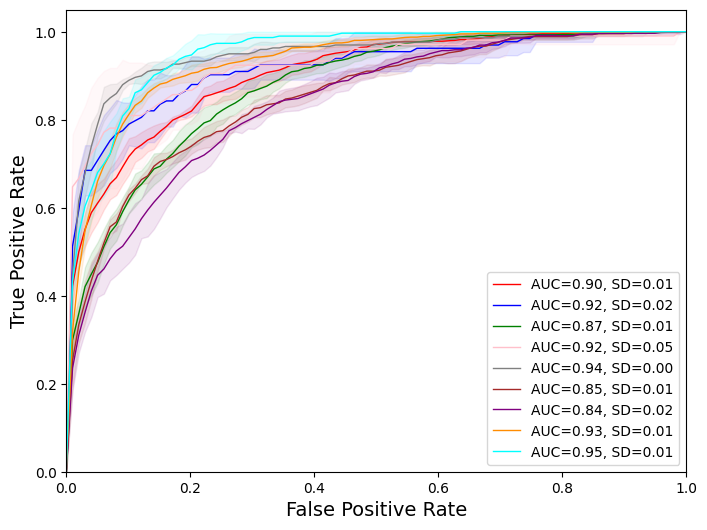

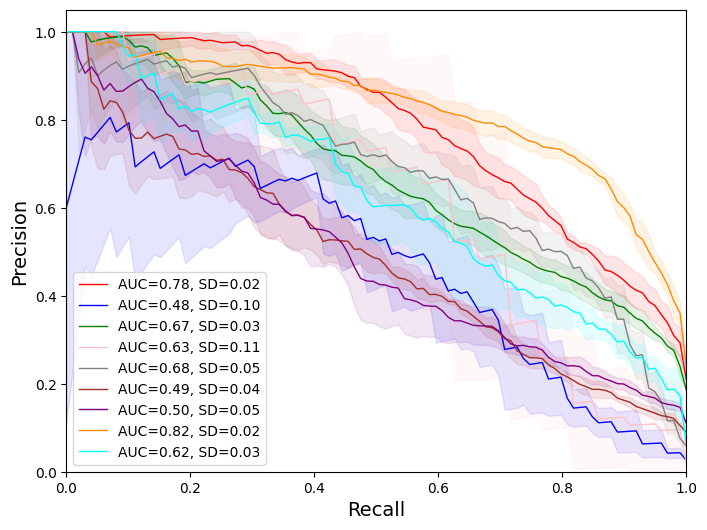

In [ ]:
report = pd.read_csv('outputs_01082023/protbert_bfd_embeddings_phrog/5CV_report.csv', index_col=0)
rocs = pd.read_csv('outputs_01082023/protbert_bfd_embeddings_phrog/5CV_rocs.csv', index_col=0)
prcs = pd.read_csv('outputs_01082023/protbert_bfd_embeddings_phrog/5CV_prcs.csv', index_col=0)


# FIGURE OUTPUTS
## ROC
plt.figure(figsize=(8,6))
lw = 1

mean_fpr = np.linspace(0, 1, 100)

for i, color in zip(range(len(lb.classes_)), colors):
    a_tpr = []
    for j in range(n_splits):
        df = rocs[rocs["class"] == lb.classes_[i]]
        df = df[df["fold"] == j]
        a_tpr.append(np.interp(mean_fpr, df["fpr"], df["tpr"]))
        a_tpr[-1][0] = 0.0
    mean_tpr = np.mean(a_tpr, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(report.loc[lb.classes_[i]]['auroc'])
    plt.plot(mean_fpr, mean_tpr, color=color,
             label='AUC={1:0.2f}, SD={2:0.2f}' ''.format(lb.classes_[i].split(' ')[0], mean_auc, std_auc),
             lw=1)
    std_tpr = np.std(a_tpr, axis=0)
    tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
    tpr_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color=color, alpha=.1)


#plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
#plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.savefig('{0}/{1}/performance_5CFV_AUROC.png' ''.format(out_dir, lm), dpi=300)
plt.show()




### PRC per class
plt.figure(figsize=(8,6))
mean_recall = np.linspace(0, 1, 100)

for i, color in zip(range(len(lb.classes_)), colors):
    a_prec = []
    for j in range(n_splits):
        df = prcs[prcs["class"] == lb.classes_[i]]
        df = df[df["fold"] == j]
        prec_fold = df['precision']
        recall_fold = df['recall']
        prec_fold = prec_fold[::-1]
        recall_fold = recall_fold[::-1]
        a_prec.append(np.interp(mean_recall, recall_fold, prec_fold))
    mean_prec = np.mean(a_prec, axis=0)
    std_prec = np.std(a_prec, axis=0)
    prec_upper = np.minimum(mean_prec + std_prec, 1)
    prec_lower = np.maximum(mean_prec - std_prec, 0)
    plt.fill_between(mean_recall, prec_lower, prec_upper, color=color, alpha=.1)
    mean_auc = np.mean(report.loc[lb.classes_[i]]['auprc'])
    std_auc = np.std(report.loc[lb.classes_[i]]['auprc'])
    plt.plot(mean_recall, mean_prec, color=color,
             label='AUC={1:0.2f}, SD={2:0.2f}' ''.format(lb.classes_[i].split(' ')[0], mean_auc, std_auc),
             lw=1)


#plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
#plt.title('Some extension of Receiver operating characteristic to multi-class')

plt.legend(loc="lower left")
plt.savefig('{0}/{1}/performance_5CFV_AUPRC.png' ''.format(out_dir, lm), dpi=300)
plt.show()

In [ ]:
report

,Unnamed: 0,precision,recall,f1-score,support,auroc,auprc,fold
0,"DNA, RNA and nucleotide metabolism",0.698630,0.718310,0.708333,213.000000,0.908588,0.805801,0
1,connector,0.375000,0.444444,0.406780,27.000000,0.895766,0.294144,0
2,head and packaging,0.679245,0.571429,0.620690,189.000000,0.890848,0.719473,0
3,integration and excision,0.538462,0.666667,0.595745,21.000000,0.989922,0.672873,0
4,lysis,0.594203,0.694915,0.640625,59.000000,0.939061,0.720359,0
...,...,...,...,...,...,...,...,...
60,transcription regulation,0.466667,0.688525,0.556291,61.000000,0.947562,0.637856,4
61,accuracy,0.615536,0.615536,0.615536,0.615536,0.615536,0.615536,4
62,macro avg,0.592122,0.610312,0.590436,1017.000000,NaN,NaN,4
63,weighted avg,0.617968,0.615536,0.609634,1017.000000,NaN,NaN,4
